# Exploration 5
# 미니프로젝트 : 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

### 1. 데이터 살펴보기

In [1]:
#필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#시각화를 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#데이터 경로 지정하기
data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')  #테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/test.csv


In [3]:
#데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))  #테스트 데이터에는 price가 없기 때문에 컬럼이 하나 적음

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
#학습 데이터에서 라벨 제거하기
y = data['price']      #y에 저장해놓기
del data['price']      #price 컬럼 제거

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
#학습 데이터와 테스트 데이터 합치기
train_len = len(data)                 #training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
data = pd.concat((data, sub), axis=0) #데이터 합치기

print(len(data))

21503


In [6]:
#표 살펴보기
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


각 컬럼이 나타내는 의미
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

### 2. 데이터 전처리

#### (1) 데이터에 결측치가 있는지를 확인한다.

<AxesSubplot:>

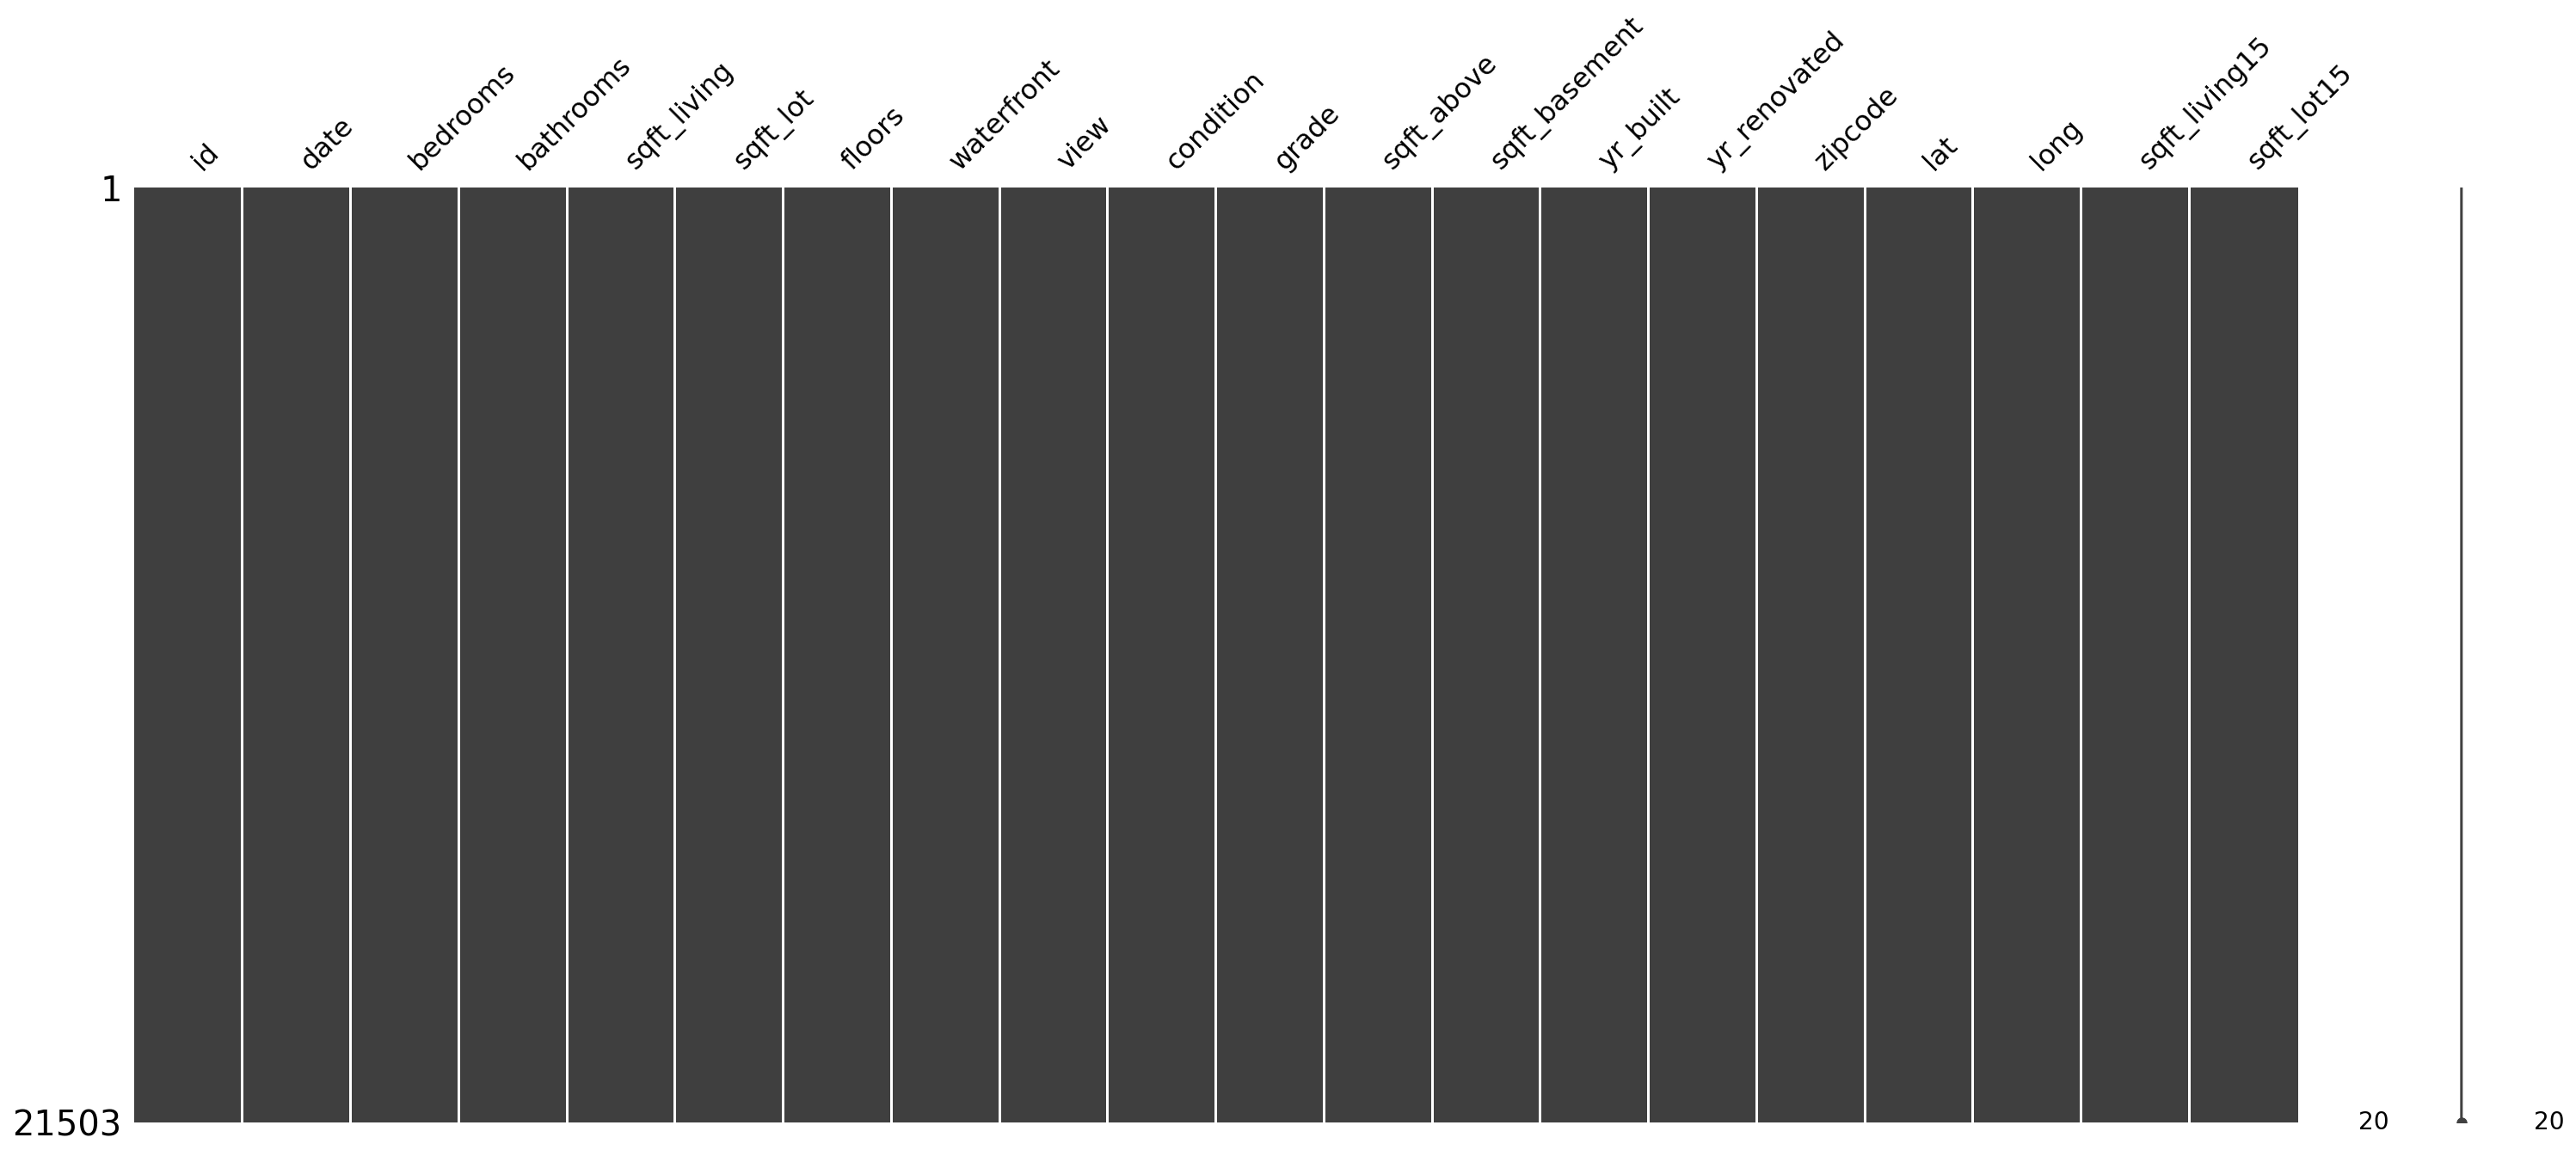

In [7]:
#간단한 전처리
msno.matrix(data)  # DataFrame을 매트릭스 모양 그대로 시각화

In [8]:
#결측치 개수 확인(결측치 없음)
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### (2) id, date 변수를 정리한다.

In [9]:
#id, date 변수 정리
sub_id = data['id'][train_len:]  # 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장해 줌
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### (3) 각 변수들의 분포를 확인한다.
-> 한쪽으로 치우친 다면 다듬어줄 필요가 있음

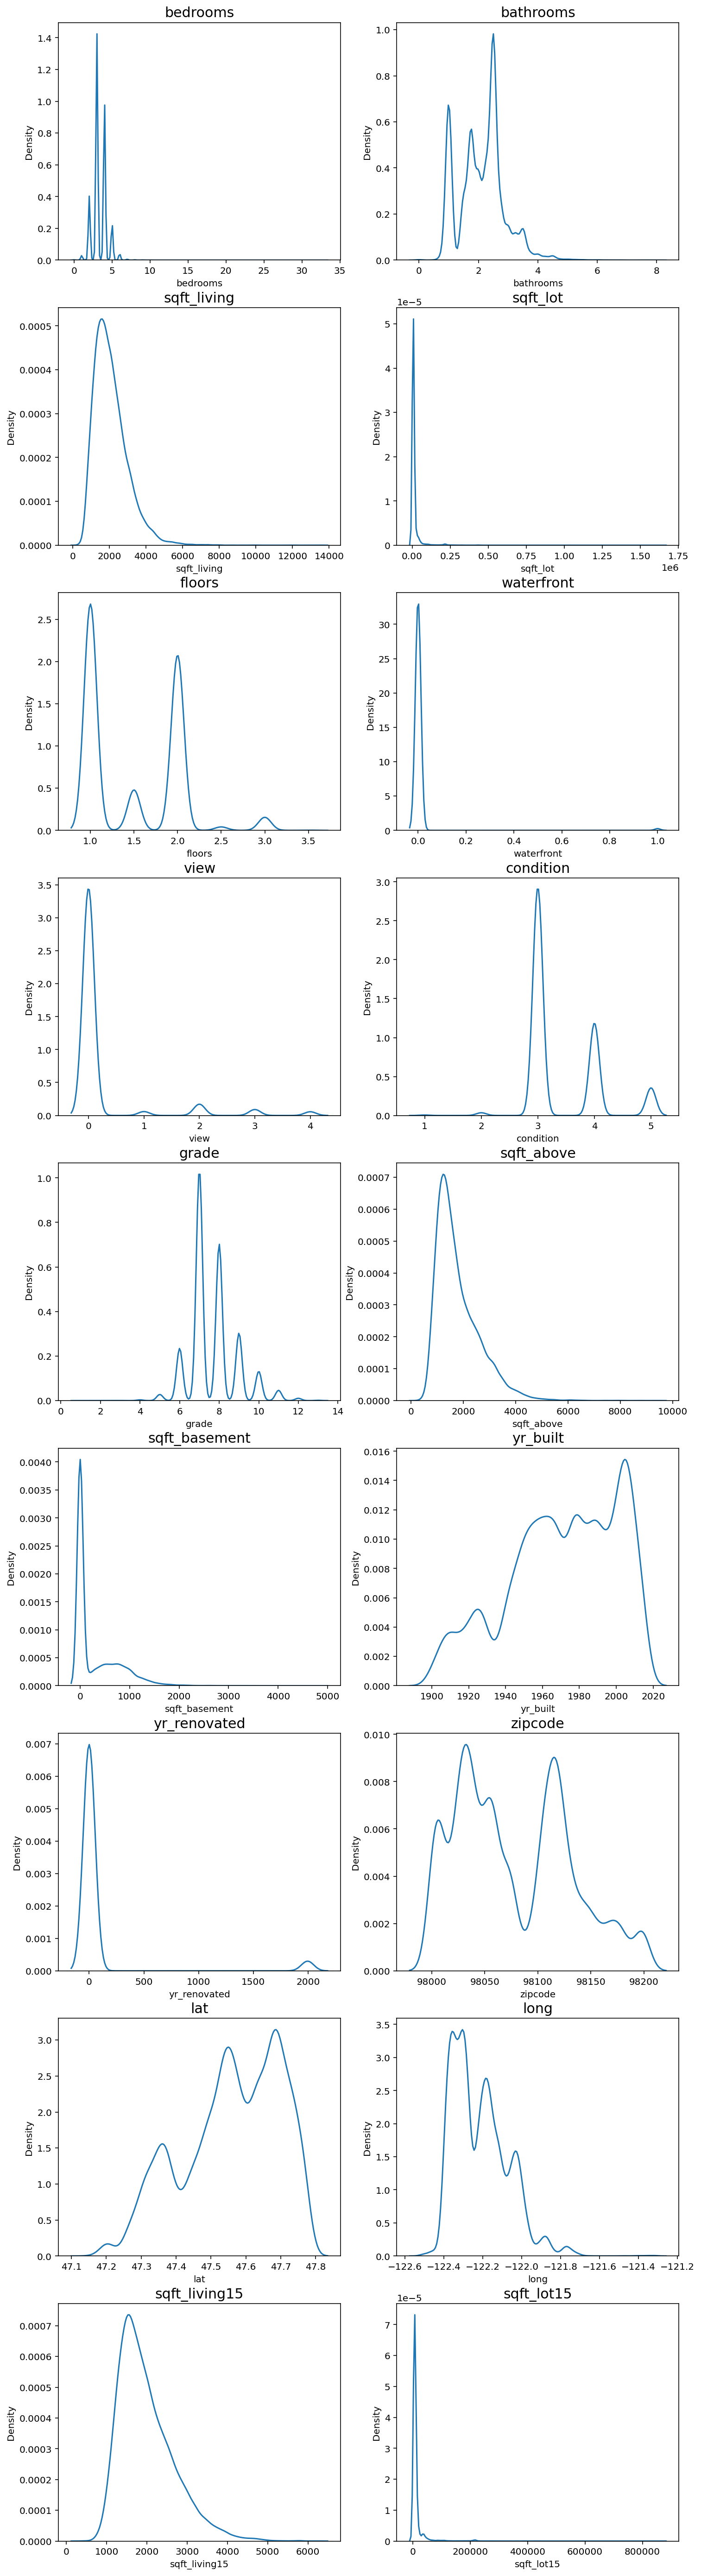

In [11]:
#가로스크롤 때문에 그래프 확인이 불편하면 figsize의 x값 조절 
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

#id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

#### (4) 데이터 분포 조정

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


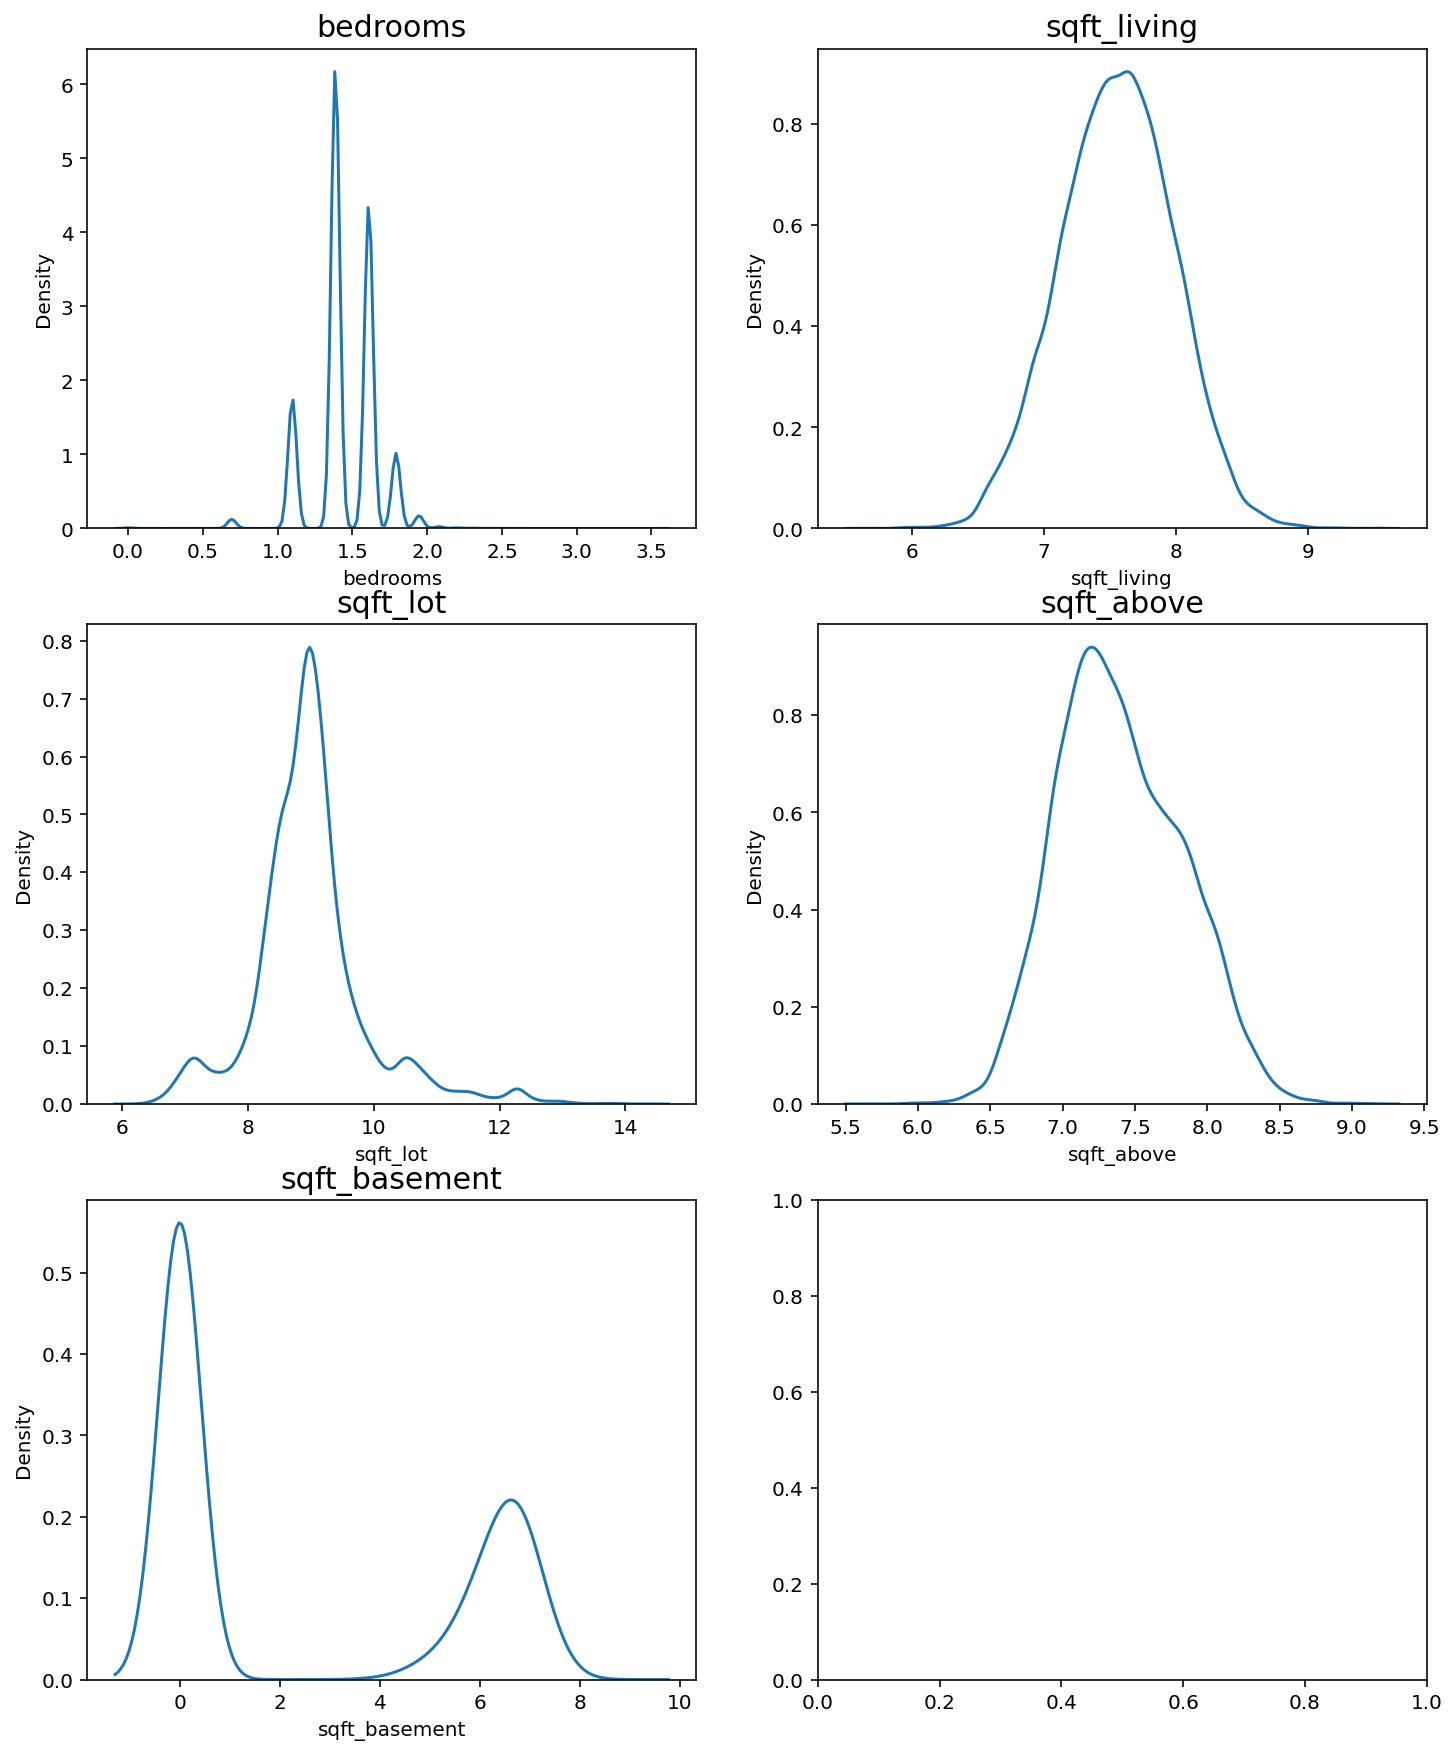

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

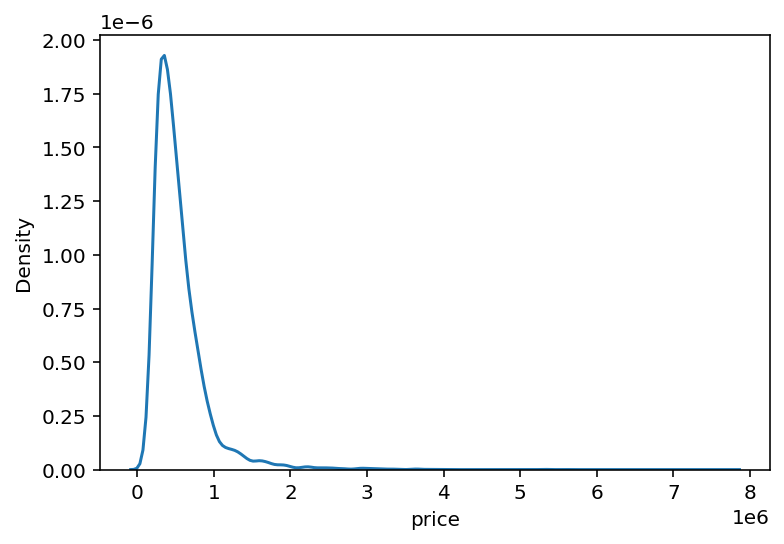

In [14]:
sns.kdeplot(y)
plt.show()

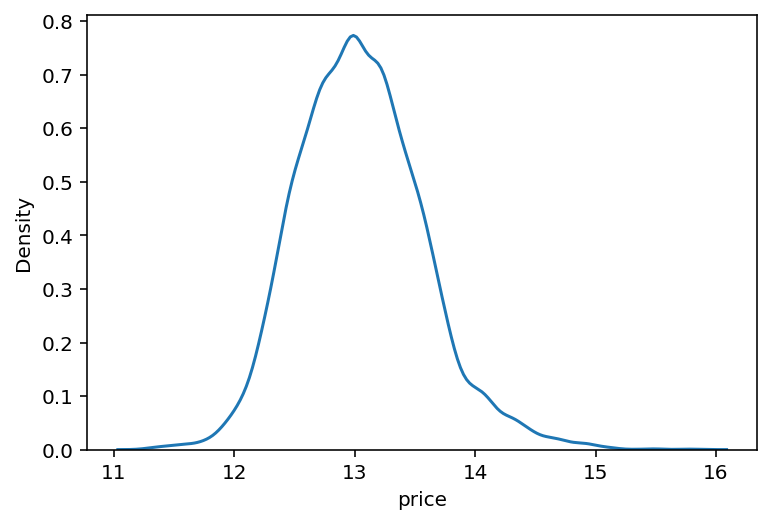

In [15]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [16]:
#위에서 저장해둔 train_len을 인덱스로 활용해서 학습 데이터와 테스트 데이터를 다시 나누어 준다.
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 3. 모델링
#### (1) Average Blending

In [17]:
#Average Blending
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


#### (2) Cross Validation

In [18]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


#### (3) Make Submission

In [19]:
#AgeragingBlending()는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤
#predictions에 그 예측 결괏값을 모아서 평균한 값을 반환해준다
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

#예측값 확인
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [20]:
#샘플 파일 확인
data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [21]:
#제출 형식에 맞게 데이터프레임 생성
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [22]:
#제출용 파일 저장
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/submission.csv


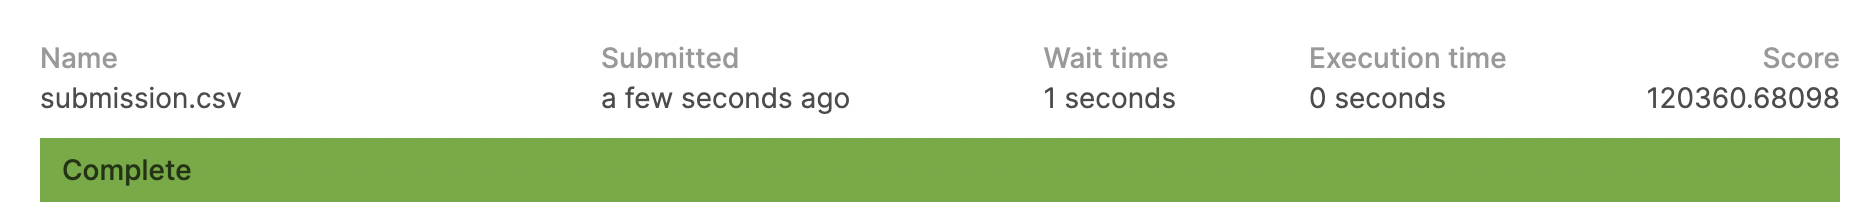

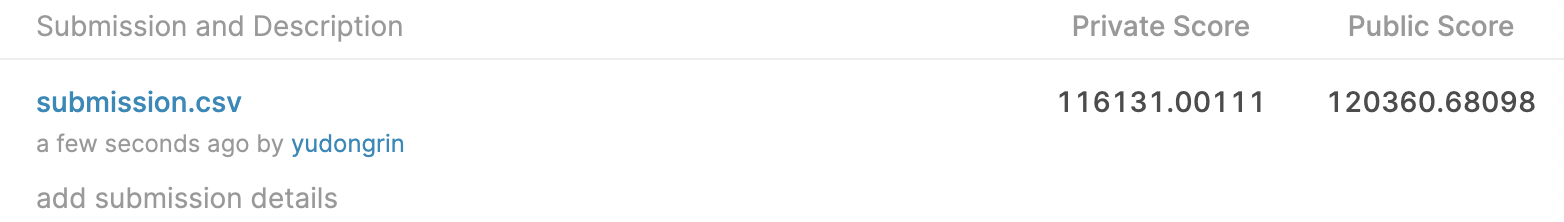

역시나... 다른 방법을 이용해서 한번 낮춰봅시다

# Score 낮추기

In [23]:
#데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#date를 정수형 데이터로 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

#타겟 데이터 price 분리
y = train['price']
del train['price']

#id 컬럼 제거
del train['id']


#테스트 데이터도 트레인 데이터와 마찬가지로 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
#test 데이터 에는 우리가 맞추어야 할 타겟 데이터인 price는 없는점 주의

del test['id']

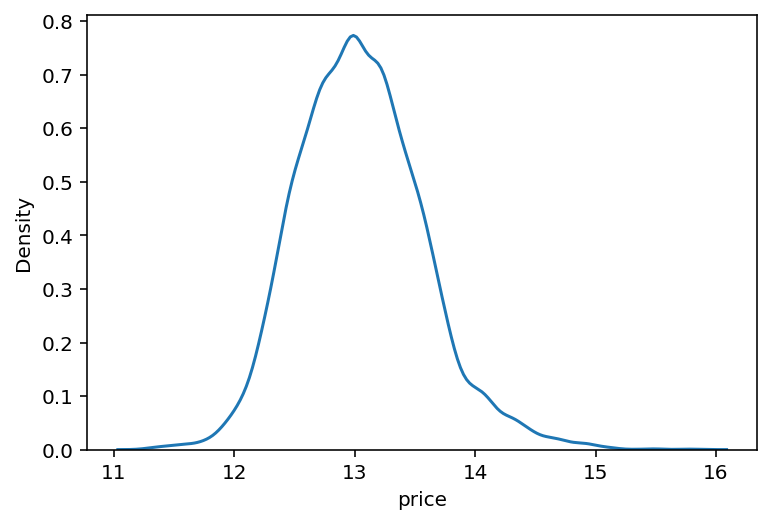

In [24]:
y = np.log1p(y)
y
sns.kdeplot(y)
plt.show()

In [25]:
#전체 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#### 모델 튜닝 간편화를 위해 함수 만들기

In [26]:
#필요한 라이브러리 임포트하기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [27]:
#RMSE 계산 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [28]:
random_state=2020        #2020으로 고정 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [29]:
#네 가지의 모델에 대해 RMSE값 구하기
df = {}

for model in models:
    #모델 이름 획득
    model_name = model.__class__.__name__

    #train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    #모델 학습
    model.fit(X_train, y_train)
    
    #예측
    y_pred = model.predict(X_test)

    #예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    #data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [30]:
#위 값을 함수로 만들기
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


#### 그리드 탐색으로 하이퍼 파라미터 튜닝하는 함수 만들기

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
#각 파라미터의 조합
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [33]:
#각 조합에 대한 점수
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [34]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [35]:
#점수 변환
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [36]:
#위 점수는 Root Mean Squared Log Error이다
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [37]:
#RMSLE가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [38]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [39]:
#그리드 탐색
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [40]:
# 해당 파라미터로 학습 후 예측
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

# 원래 스케일로 되돌리기
prediction = np.expm1(prediction)

In [41]:
#샘플 파일 가져오기
data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [42]:
#모델의 예측값 덮어쓰기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [43]:
# 파일 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [44]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [45]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


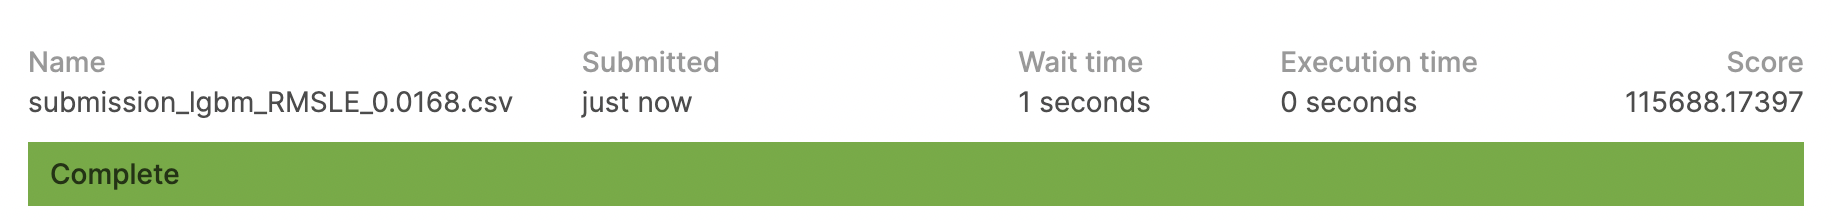

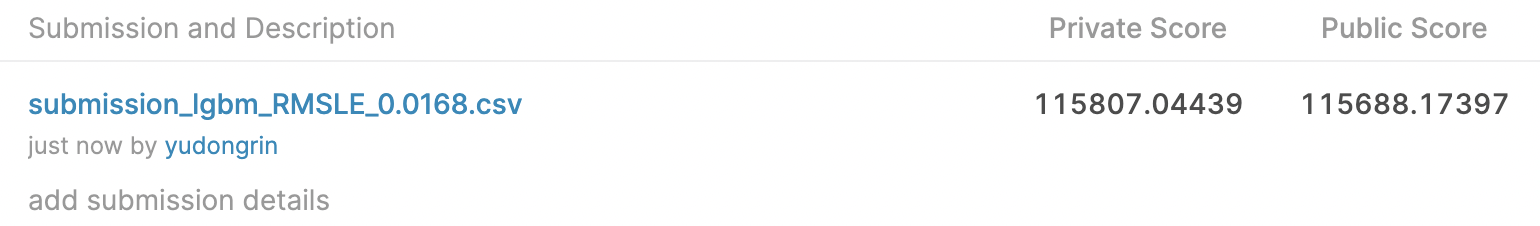

우리에게 가장 중요한 private score인데 그닥 안 떨어졌네요...

public score만 낮아지고

또 다른 방법을 찾아봅시다...

# 다른 방법(한번 더 하면 낮아질수도..?)
진짜 단순히 그냥 XGBRegressor가 낮아보여서 접근함

In [46]:
#데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/Exploration5/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#date를 정수형 데이터로 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

#타겟 데이터 price 분리
y = train['price']
del train['price']

#id 컬럼 제거
del train['id']


#테스트 데이터도 트레인 데이터와 마찬가지로 전처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
#test 데이터 에는 우리가 맞추어야 할 타겟 데이터인 price는 없는점 주의해야 함

del test['id']
y = np.log1p(y)

In [47]:
#먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성
model = XGBRegressor(
    learning_rate =0.1, 
    n_estimators=1000, 
    max_depth=5, 
    min_child_weight=1, 
    gamma=0, 
    nthread=4, 
    scale_pos_weight=1, 
    seed=27
)
save_submission(model, train, y, test, 'XGB', rmsle='0.0168')

/aiffel/aiffel/Exploration5/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0168.csv saved!


score를 낮추는 방법을 이용했을때 아직 조금 과적합하다고 판단해서 learning_rate, n_estimators 외에도 조금 더 추가하면 과적합을 제어할 수 있을것같아서 위와 같이 작성함

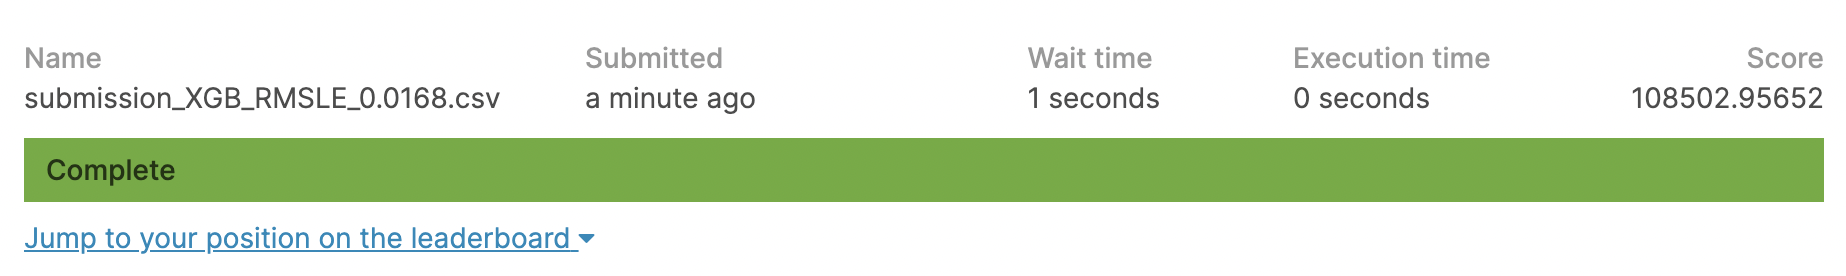

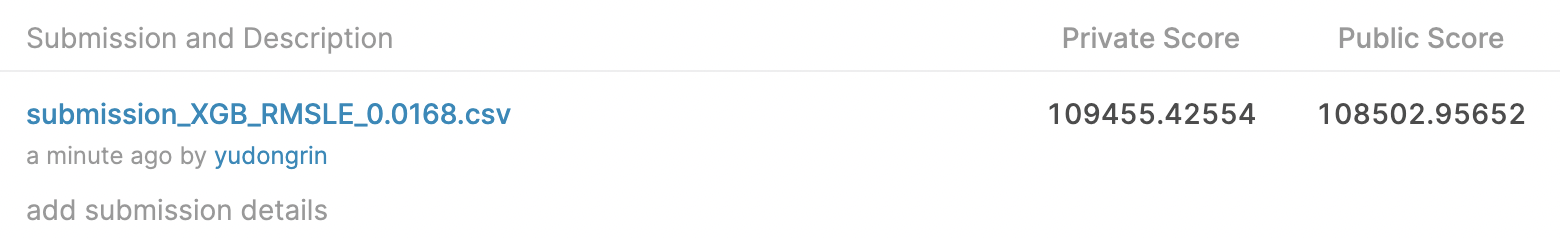

오예 떨어졌다 떨어졌어!!

# 회고
처음에 LMS에서 작성된 코드를 따라 적으며 결과를 캐글에 올렸더니 120000점 정도 나왔다.

두번째 시도에서는 score를 낮추어서 했지만 역시나 110000점 이하로 내려가는 건 어려운 일이라는 것을 알았다.

그래서 고민을 하다가 lightGBM와 XGBoost 이 둘을 사용해서 점수를 낮출 수 있겠다는 생각을 했다.

그래서 구글 검색을 활용해서 많은 자료들을 토대로 과적합을 잡을 수 있었다.(참고한 자료를 첨부하고 싶었지만 자료를 그냥 닫아 버려서 없음. 혹시나 나중에 찾게 된다면 꼭 첨부하도록 할께요...ㅎ)

시간이 된다면 또 다른 방법을 이용해서 점수를 더 낮춰보는것도 괜찮을 것같다.